In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from filter_pheno import add_visit_info,filtering_HF,filtering_MI
def create_clump_input(target_name):
    # LV_radial_strain_global_file = 'result/test_bin_out_firth_LV_radial_strain_global.regenie'
    input_path = f"result/test_bin_out_firth_{target_name}.regenie"
    df = pd.read_csv(input_path, sep='\s+').sort_values("GENPOS")
    df['P'] = 10 ** -df['LOG10P']
    
    # Now extract the SNP IDs and p-values into a new DataFrame
    plink_input = df[['ID', 'P']]
    
    # Rename the columns to what PLINK expects
    plink_input.columns = ['SNP', 'P']
    
    # Save this to a text file
    plink_input.to_csv(f'clump_result/pre_clump_file/plink_input_{target_name}.txt', sep='\t', index=False)
create_clump_input('LV_radial_strain_global')
create_clump_input('LV_ejection_fraction')
create_clump_input('LV_longitudinal_strain_global')
create_clump_input('LV_circumferential_strain_global')

In [2]:
def visualize_clump(target):
    path = f'clump_result/plink_clump_{target}.clumped'
    df = pd.read_csv(path, delim_whitespace=True)

    df['CHR'] = df['CHR'].astype('category')
    
    # Sorting by chromosome for plotting
    df = df.sort_values('CHR')
    df['ind'] = range(len(df))
    df["LOG10P"] = -np.log10(df["P"])
    # Group the data by chromosome
    df_grouped = df.groupby('CHR')
    
    # Set the figure size
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)
    
    # Colors for the plot
    colors = ['darkred', 'darkgreen', 'darkblue', 'gold']
    
    # Lists for x-ticks and labels
    x_labels = []
    x_labels_pos = []
    
    # Plot each group
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='LOG10P', color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0]) / 2))
    
    # Set x-ticks and labels
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    
    # Drawing the significance threshold line
    threshold = -np.log10(5e-8)  # for p-value of 5e-8
    ax.axhline(y=threshold, color='r', linestyle='--')
    
    # X and Y axis labels
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-Log10(p-value)')
    
    # Show the graph
    plt.show()


    

In [21]:

# from pyensembl import EnsemblRelease
def plot_genomic_data(df_path,gene_name_df_path,clumped_df_path):
# def plot_genomic_data(df,gene_name_df):
    # Read the data
    df = pd.read_csv(df_path, sep='\s+').sort_values("GENPOS")
    gene_name_df = pd.read_csv(gene_name_df_path)
    clumped_df = pd.read_csv(clumped_df_path,delim_whitespace=True)
    
    # Convert 'CHROM' to a categorical data type for easier sorting and plotting
    threshold = -np.log10(5e-8)
    
    df['CHR'] = df['CHROM'].astype('category')

    # Sorting by chromosome for plotting
    df = df.sort_values('CHR')
    df['ind'] = range(len(df))

    # Group the data by chromosome
    df = pd.merge(df, gene_name_df[['ID', 'GENE_NAME']], on='ID', how='left')
    
    # Filter the dataframe for SNPs above the threshold
    significant_snps = df[df['LOG10P'] > threshold]

    significant_snps = significant_snps[significant_snps["ID"].isin(clumped_df["SNP"].values)]
    # Group by 'GENE_NAME', then select the SNP with the smallest p-value for each gene
    significant_snps = significant_snps.loc[significant_snps.groupby(["CHROM","GENE_NAME"])['LOG10P'].idxmax()]

    
    df_grouped = df.groupby('CHR')
    
    # Set the figure size
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    # Colors for the plot
    colors = ['darkred', 'darkgreen', 'darkblue', 'gold']

    # Lists for x-ticks and labels
    x_labels = []
    x_labels_pos = []
    print("Start plotting")
    
    # Plot each group
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='LOG10P', color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0]) / 2))

    for _, row in significant_snps.iterrows():

        ax.text(row['ind'], row['LOG10P'], row['GENE_NAME'], fontsize=9)    

    # Set x-ticks and labels
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)

    # Drawing the significance threshold line
      # for p-value of 5e-8
    ax.axhline(y=threshold, color='r', linestyle='--')

    # X and Y axis labels
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-Log10(p-value)')

    # Show the graph
    plt.show()



In [22]:
clumped_df_path = f'clump_result/plink_clump_LV_radial_strain_global.clumped'
clumped_df = pd.read_csv(clumped_df_path,delim_whitespace=True)
clumped_df

,CHR,F,SNP,BP,P,TOTAL,NSIG,S05,S01,S001,S0001,SP2
0,1,1,1:116297758:C:A,116297758,1.920000e-14,97,0,0,0,0,97,"1:116257891:C:T(1),1:116259062:T:C(1),1:116259..."
1,6,1,6:36645988:G:C,36645988,3.690000e-14,25,0,0,0,0,25,"6:36616600:C:T(1),6:36617652:T:C(1),6:36618821..."
2,1,1,1:116279406:C:A,116279406,1.170000e-12,14,0,0,0,0,14,"1:116251879:T:G(1),1:116252312:A:T(1),1:116256..."
3,2,1,2:179609245:A:G,179609245,5.540000e-12,46,0,0,0,0,46,"2:179411665:A:G(1),2:179414633:C:A(1),2:179430..."
4,6,1,6:36648364:T:C,36648364,5.830000e-12,14,0,0,0,0,14,"6:36629444:C:T(1),6:36629714:C:T(1),6:36630525..."
...,...,...,...,...,...,...,...,...,...,...,...,...
536,15,1,15:90523434:A:G,90523434,9.950000e-05,29,7,19,0,3,0,"15:90518751:A:C(1),15:90519617:G:A(1),15:90523..."
537,5,1,5:178957177:G:T,178957177,9.950000e-05,4,3,0,0,1,0,5:178962289:C:T(1)
538,17,1,17:41859648:A:G,41859648,9.970000e-05,28,19,6,0,3,0,"17:41826492:C:T(1),17:41866596:T:C(1),17:41938..."
539,8,1,8:8517919:G:A,8517919,9.980000e-05,14,0,3,10,1,0,"8:8499310:G:A(1),8:8502719:G:C(1),8:8502881:C:..."


Start plotting


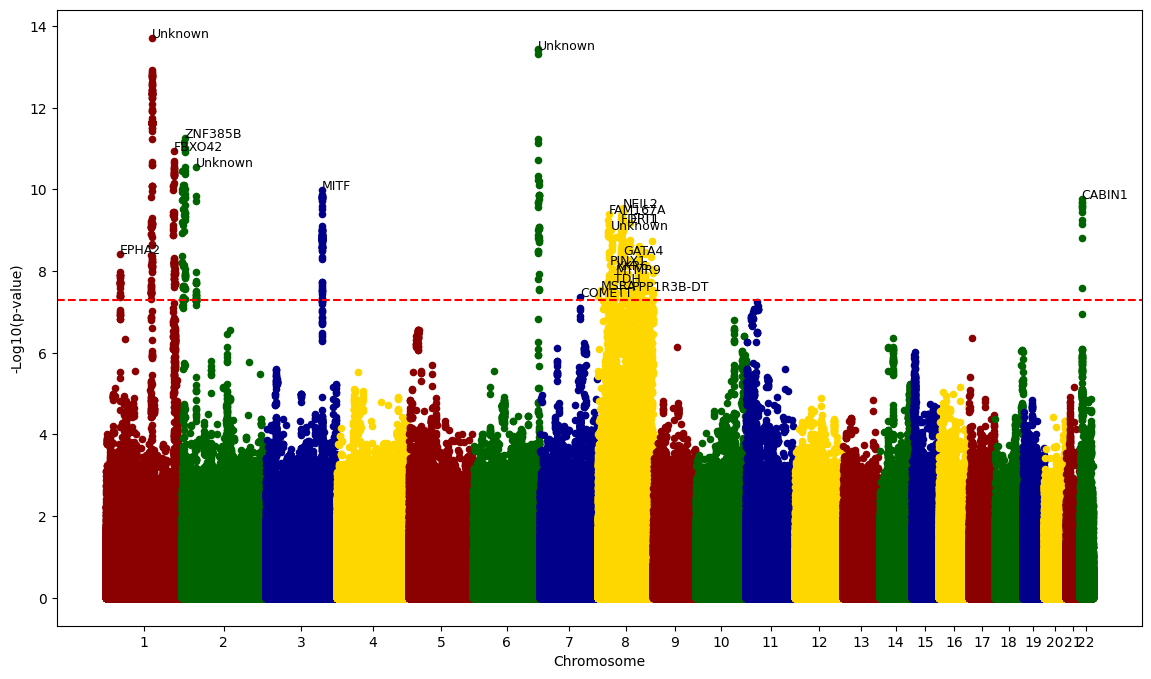

In [27]:
df_PATH = 'result/test_bin_out_firth_LV_radial_strain_global.regenie'
gene_name_PATH = "gene_name_df/LV_radial_strain_global.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_radial_strain_global.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)


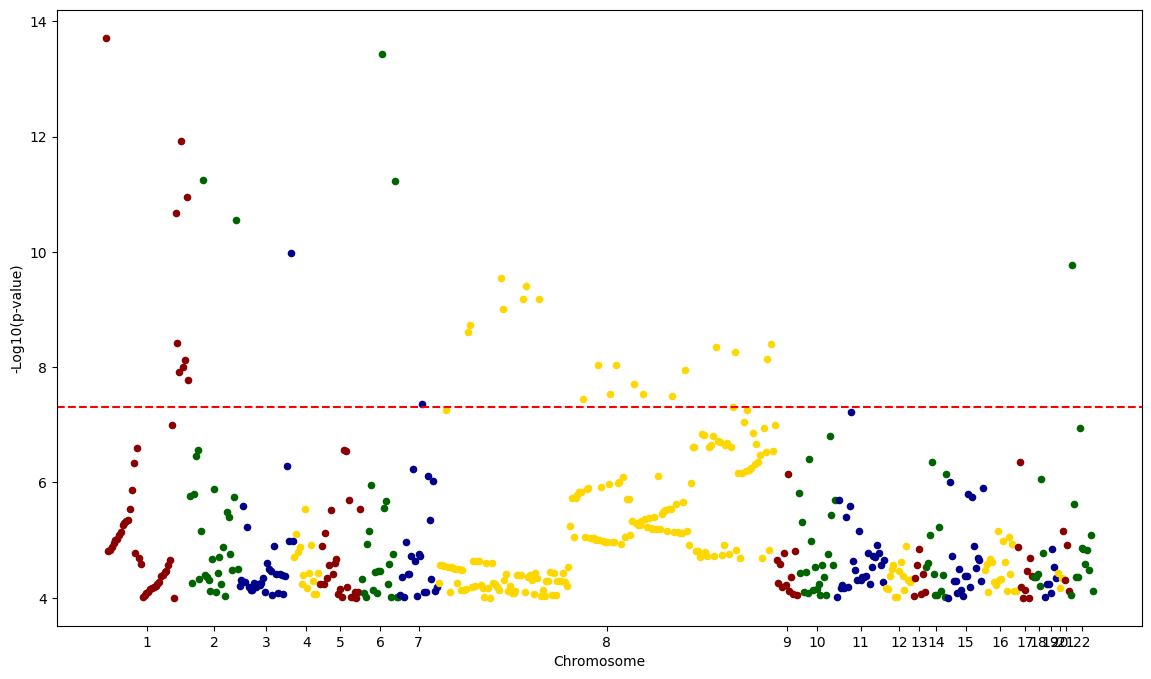

In [28]:
visualize_clump("LV_radial_strain_global")

Start plotting


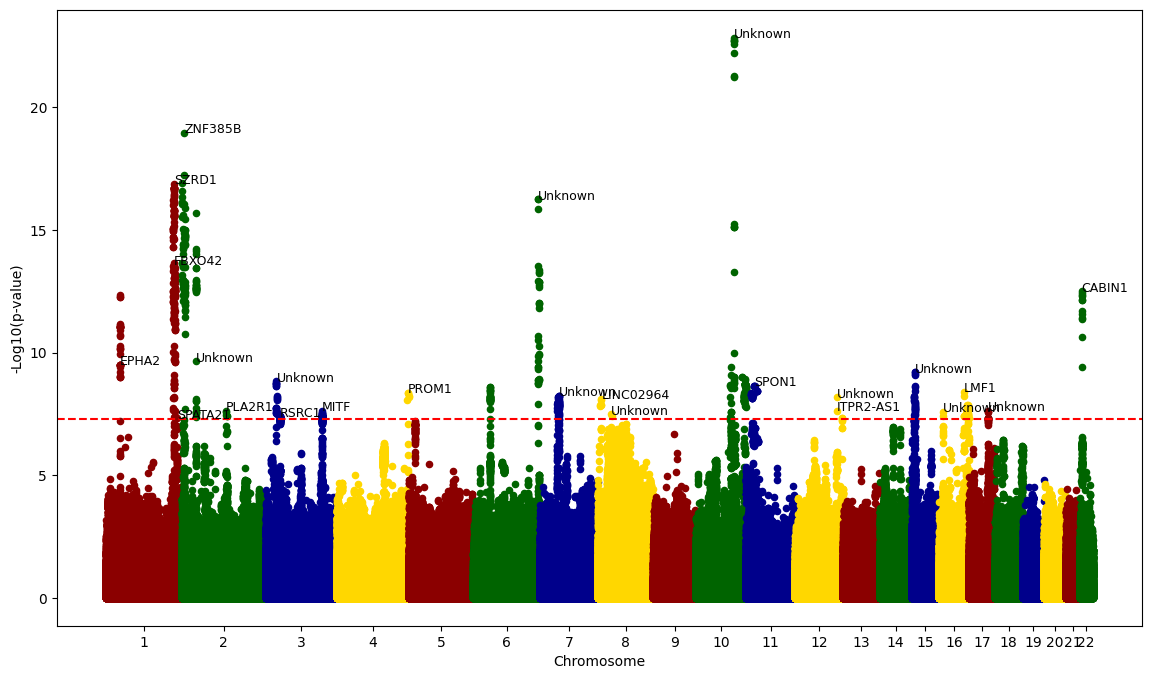

In [29]:
df_PATH = 'result/test_bin_out_firth_LV_circumferential_strain_global.regenie'
gene_name_PATH = "gene_name_df/LV_circumferential_strain_global.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_circumferential_strain_global.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)

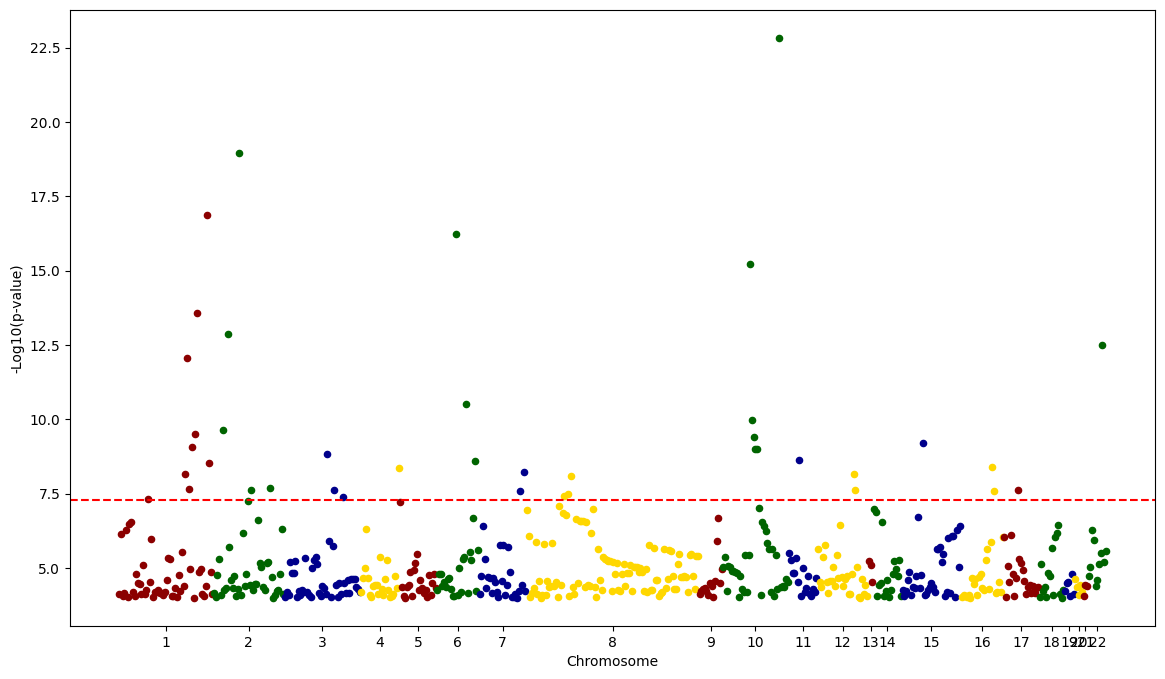

In [30]:
visualize_clump("LV_circumferential_strain_global")

Start plotting


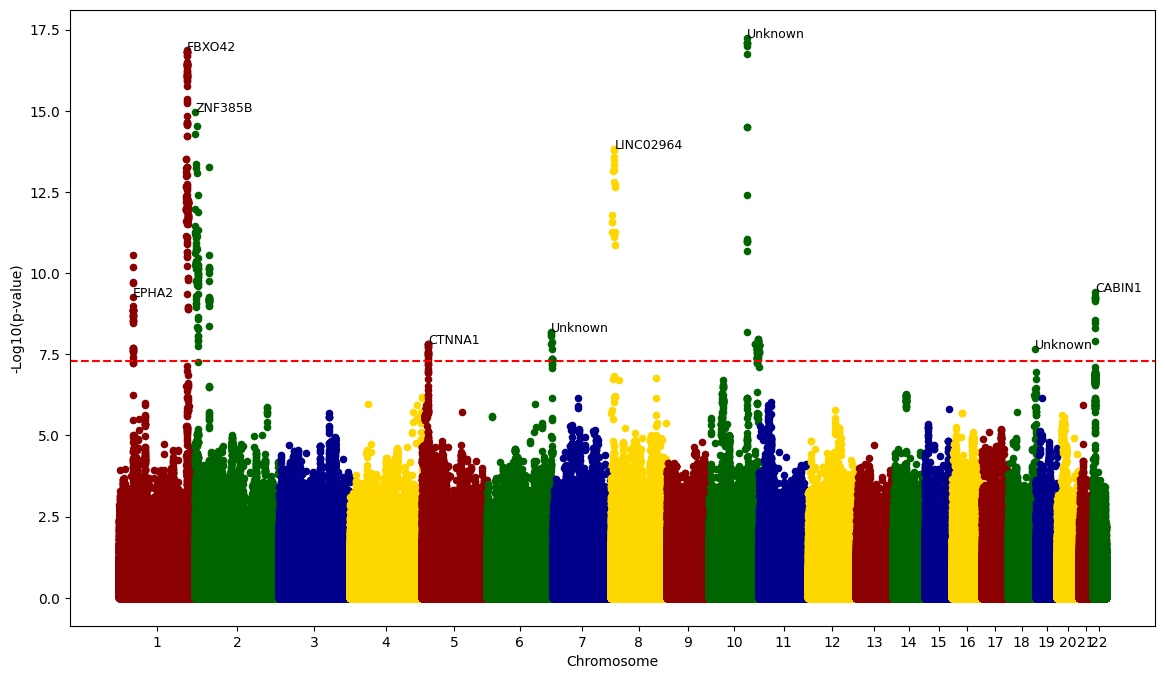

In [31]:
df_PATH = 'result/test_bin_out_firth_LV_ejection_fraction.regenie'
gene_name_PATH = "gene_name_df/LV_ejection_fraction.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_ejection_fraction.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)

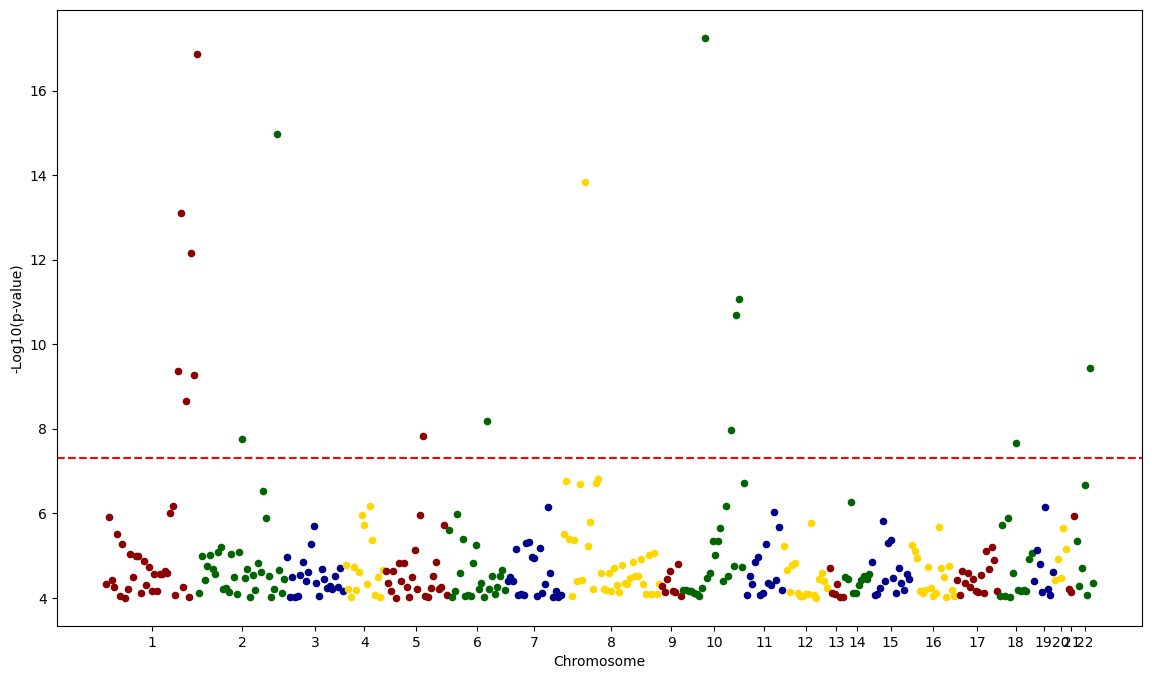

In [32]:
visualize_clump("LV_ejection_fraction")

Start plotting


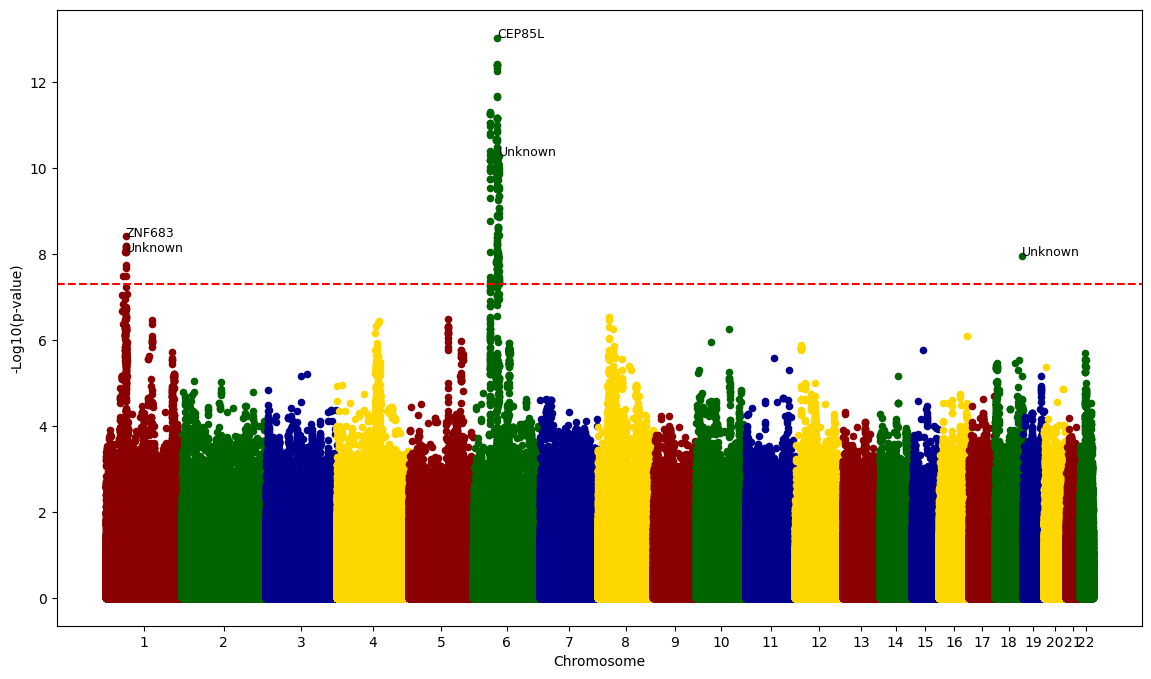

In [33]:
df_PATH = 'result/test_bin_out_firth_$.regenie'
gene_name_PATH = "gene_name_df/LV_longitudinal_strain_global.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_longitudinal_strain_global.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)

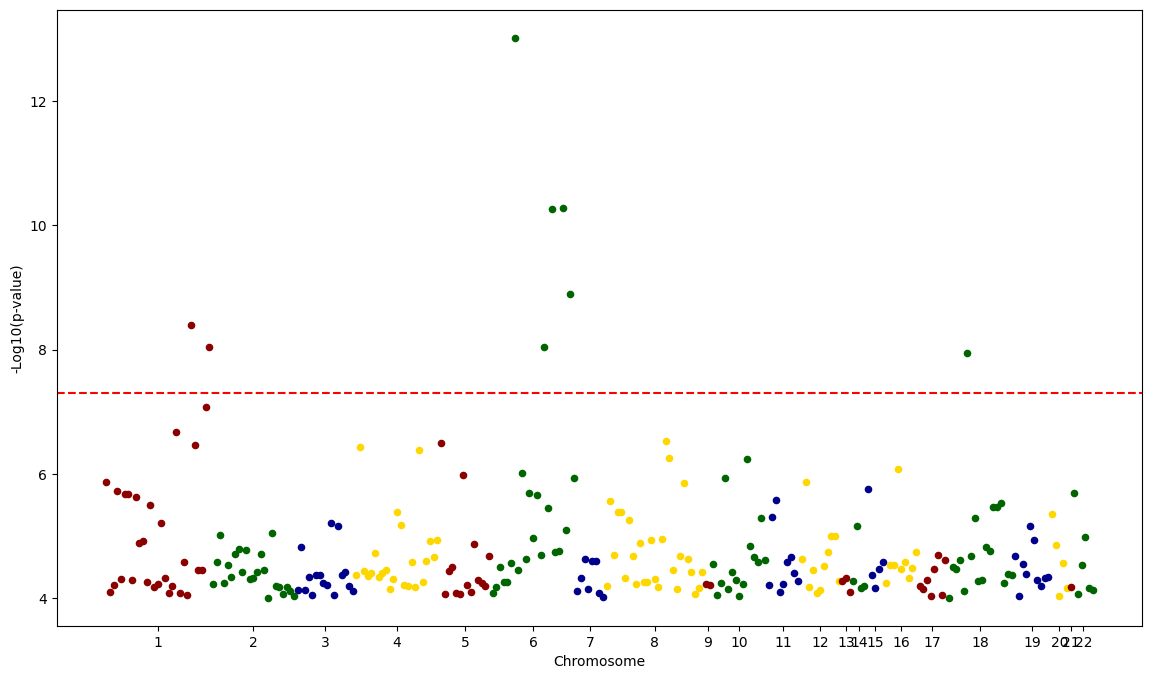

In [34]:
visualize_clump("LV_longitudinal_strain_global")

# Here is to handle gene position to gene mapping



In [10]:
gene_name_df = pd.read_csv("HGNC_genes_HSgr38.txt")
accepted_chrome = [str(i) for i in range(23)]
gene_name_df = gene_name_df[gene_name_df["Chromosome/scaffold name"].isin(accepted_chrome)]
gene_name_df

,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HGNC symbol
1042,21,8238859,8239092,NaN
1043,21,8420675,8421003,NaN
1044,21,10576292,10576587,CYCSP41
1045,21,7385058,7388799,NaN
1046,21,10028361,10029855,NaN
...,...,...,...,...
70702,1,89579592,89579654,NaN
70703,1,31919563,31938010,NaN
70704,1,11869,14409,NaN
70705,1,14696,24886,WASH7P


In [8]:
def mapping_gene_name(gene_name_df, target):
    df_path = f'result/test_bin_out_firth_{target}.regenie'
    clumped_df_path = f'clump_result/plink_clump_{target}.clumped'
    df = pd.read_csv(df_path, sep='\s+').sort_values("GENPOS")
    clumped_df = pd.read_csv(clumped_df_path,delim_whitespace=True)
    # Convert 'CHROM' to a categorical data type for easier sorting and plotting
    df['CHR'] = df['CHROM'].astype('category')
    threshold = -np.log10(5e-8)
    # Sorting by chromosome for plotting
    df = df.sort_values('CHR')
    df = df[df["LOG10P"] > threshold]

    # Map gene names
    def find_gene_name(row):
        # Filter gene_name_df for the current chromosome and gene position range
        relevant_genes = gene_name_df[
            (gene_name_df['Chromosome/scaffold name'].astype(str) == str(row['CHR'])) &
            (gene_name_df['Gene start (bp)'] <= row['GENPOS']) &
            (gene_name_df['Gene end (bp)'] >= row['GENPOS'])
        ]
        # If any relevant genes are found, return the first one's HGNC symbol
        if not relevant_genes.empty:
            return relevant_genes.iloc[0]['HGNC symbol']
        else:
            return 'Unknown' 

    # Apply the function to each row in df
    df['GENE_NAME'] = df.apply(find_gene_name, axis=1)
    df['GENE_NAME'] = df['GENE_NAME'].fillna("Unknown")
    df = df[df["ID"].isin(clumped_df["SNP"].values)]
    df.to_csv(f"gene_name_df/clumped_{target}.csv")
    return df

In [11]:
mapping_gene_name(gene_name_df,"LV_ejection_fraction")

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,CHR,GENE_NAME
39007,1,16129320,1:16129320:T:C,T,C,0.461282,33421,ADD,0.210181,0.035154,35.7470,8.64845,NaN,1,EPHA2
39018,1,16131324,1:16131324:G:A,G,A,0.223632,33421,ADD,-0.260343,0.041920,38.5691,9.27696,NaN,1,EPHA2
39454,1,16325518,1:16325518:A:G,A,G,0.390279,33421,ADD,-0.267966,0.035852,55.8636,13.10970,NaN,1,FBXO42
39352,1,16296039,1:16296039:A:G,A,G,0.327100,33421,ADD,0.266596,0.037122,51.5752,12.16170,NaN,1,FBXO42
39536,1,16340761,1:16340761:T:C,C,T,0.413183,33421,ADD,0.301962,0.035371,72.8806,16.86100,NaN,1,FBXO42
39530,1,16339419,1:16339419:G:C,G,C,0.225741,33421,ADD,0.260167,0.041693,38.9392,9.35930,NaN,1,FBXO42
985380,2,179514433,2:179514433:T:C,T,C,0.192065,33421,ADD,0.354457,0.044217,64.2602,14.96250,NaN,2,ZNF385B
985560,2,179628369,2:179628369:G:T,T,G,0.153511,33421,ADD,0.273502,0.048580,31.6961,7.74404,NaN,2,ZNF385B
2521825,5,138720156,5:138720156:C:T,T,C,0.326771,33421,ADD,0.210758,0.037227,32.0516,7.82352,NaN,5,CTNNA1
2754900,6,36645988,6:36645988:G:C,G,C,0.197765,33421,ADD,0.254955,0.043953,33.6471,8.17998,NaN,6,Unknown


In [12]:
mapping_gene_name(gene_name_df,"LV_radial_strain_global")
mapping_gene_name(gene_name_df,"LV_circumferential_strain_global")
mapping_gene_name(gene_name_df,"LV_longitudinal_strain_global")
mapping_gene_name(gene_name_df,"LV_ejection_fraction")

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,CHR,GENE_NAME
39007,1,16129320,1:16129320:T:C,T,C,0.461282,33421,ADD,0.210181,0.035154,35.7470,8.64845,NaN,1,EPHA2
39018,1,16131324,1:16131324:G:A,G,A,0.223632,33421,ADD,-0.260343,0.041920,38.5691,9.27696,NaN,1,EPHA2
39454,1,16325518,1:16325518:A:G,A,G,0.390279,33421,ADD,-0.267966,0.035852,55.8636,13.10970,NaN,1,FBXO42
39352,1,16296039,1:16296039:A:G,A,G,0.327100,33421,ADD,0.266596,0.037122,51.5752,12.16170,NaN,1,FBXO42
39536,1,16340761,1:16340761:T:C,C,T,0.413183,33421,ADD,0.301962,0.035371,72.8806,16.86100,NaN,1,FBXO42
39530,1,16339419,1:16339419:G:C,G,C,0.225741,33421,ADD,0.260167,0.041693,38.9392,9.35930,NaN,1,FBXO42
985380,2,179514433,2:179514433:T:C,T,C,0.192065,33421,ADD,0.354457,0.044217,64.2602,14.96250,NaN,2,ZNF385B
985560,2,179628369,2:179628369:G:T,T,G,0.153511,33421,ADD,0.273502,0.048580,31.6961,7.74404,NaN,2,ZNF385B
2521825,5,138720156,5:138720156:C:T,T,C,0.326771,33421,ADD,0.210758,0.037227,32.0516,7.82352,NaN,5,CTNNA1
2754900,6,36645988,6:36645988:G:C,G,C,0.197765,33421,ADD,0.254955,0.043953,33.6471,8.17998,NaN,6,Unknown


#### Visualization of Normality of all four phenotypes, and if they are skewed, then we need to apply transformation

In [28]:
x = pd.read_csv(f"../../../data/adjusted_filtered_LV_ejection_fraction.tsv", sep="\t")
x = x[~x["LV_ejection_fraction"].isnull()]
x

,FID,IID,LV_ejection_fraction
0,1000192,1000192,66.3392
1,1000330,1000330,53.1538
2,1000420,1000420,62.4822
3,1000521,1000521,59.3075
4,1000632,1000632,62.4959
...,...,...,...
35387,6024152,6024152,57.3449
35388,6024474,6024474,64.9692
35389,6024840,6024840,55.4608
35390,6024857,6024857,52.8480


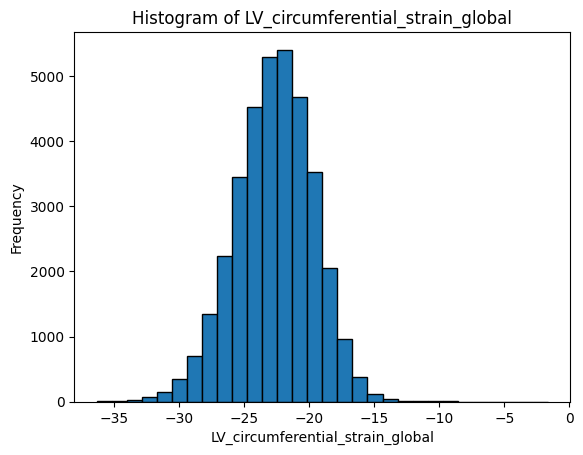

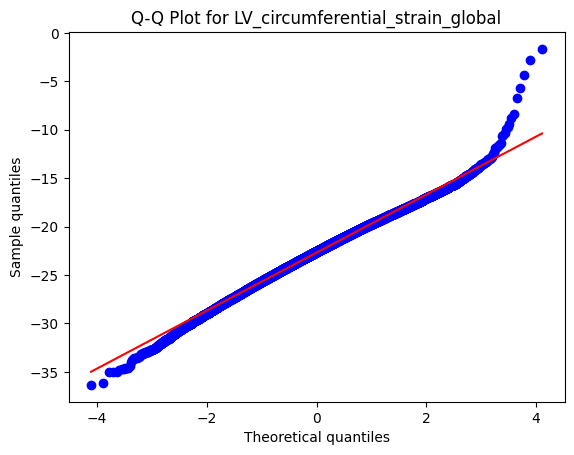

/opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test for LV_circumferential_strain_global: statistic = 0.9965967535972595, p-value = 6.54977496983802e-27
Kolmogorov-Smirnov Test for LV_circumferential_strain_global: statistic = 0.9999377104760712, p-value = 0.0


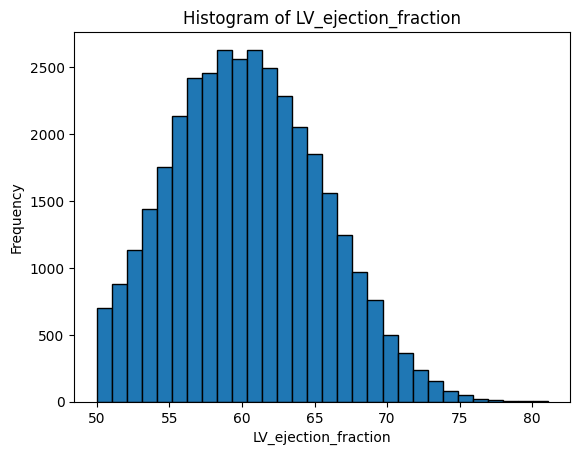

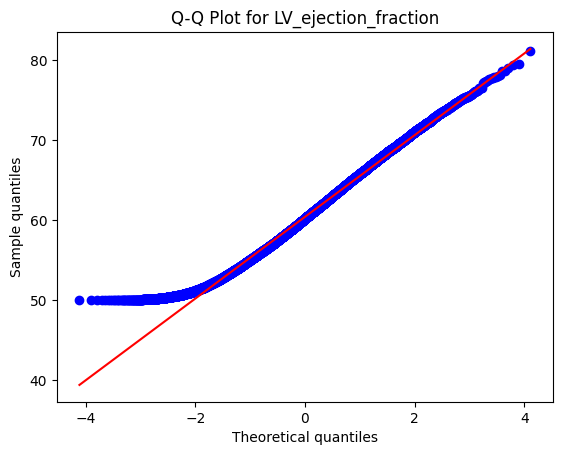

/opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test for LV_ejection_fraction: statistic = 0.9906664490699768, p-value = 1.3260487367905744e-41
Kolmogorov-Smirnov Test for LV_ejection_fraction: statistic = 1.0, p-value = 0.0


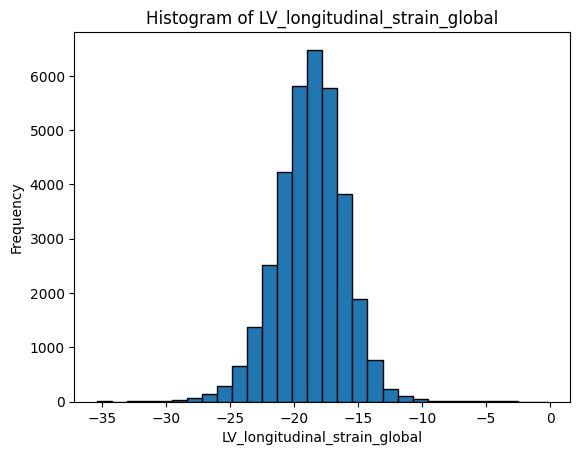

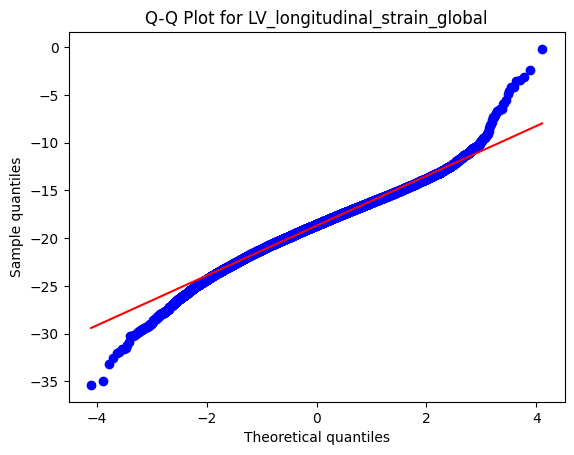

/opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test for LV_longitudinal_strain_global: statistic = 0.9899263381958008, p-value = 2.205643782847262e-42
Kolmogorov-Smirnov Test for LV_longitudinal_strain_global: statistic = 0.999838132090021, p-value = 0.0


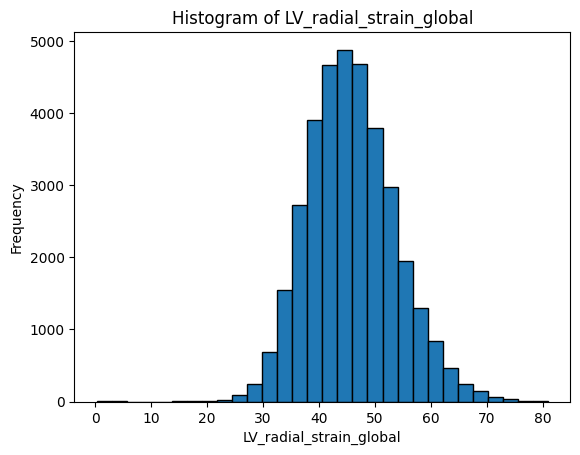

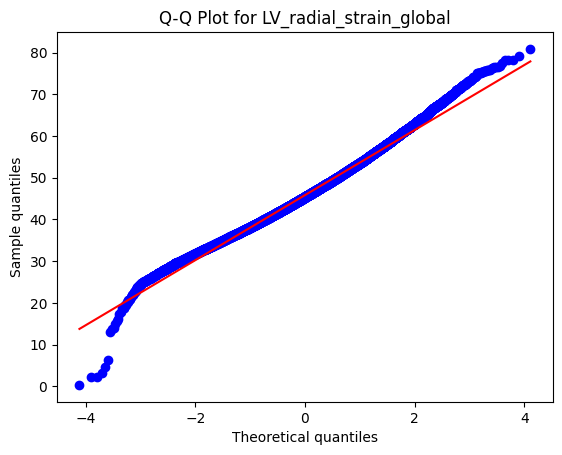

Shapiro-Wilk Test for LV_radial_strain_global: statistic = 0.9923175573348999, p-value = 1.7227385355504332e-38
Kolmogorov-Smirnov Test for LV_radial_strain_global: statistic = 0.9998844377570093, p-value = 0.0


/opt/applications/python/3.8.3/gnu/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [27]:
phenotype_list = ["LV_circumferential_strain_global", "LV_ejection_fraction", "LV_longitudinal_strain_global", "LV_radial_strain_global"]

def visualize_pheno(pheno_name):
    pheno_path = f"../../../data/adjusted_filtered_{pheno_name}.tsv"
    pheno_df = pd.read_csv(pheno_path, sep="\t")
    pheno_df = pheno_df[~pheno_df[f"{pheno_name}"].isnull()]
    
    # Plot histogram
    plt.figure()
    plt.hist(pheno_df.iloc[:, 2], bins=30, edgecolor='black')
    plt.title(f'Histogram of {pheno_name}')
    plt.xlabel(f'{pheno_name}')
    plt.ylabel('Frequency')
    plt.show()
    
    # Plot Q-Q plot
    plt.figure()
    stats.probplot(pheno_df.iloc[:, 2], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {pheno_name}')
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Sample quantiles')
    plt.show()
    
    # Shapiro-Wilk Test for normality
    normal_statistic, normal_pvalue = stats.shapiro(pheno_df.iloc[:, 2])
    print(f"Shapiro-Wilk Test for {pheno_name}: statistic = {normal_statistic}, p-value = {normal_pvalue}")
    
    # Kolmogorov-Smirnov Test for normality
    ks_statistic, ks_pvalue = stats.kstest(pheno_df.iloc[:, 2], 'norm')
    print(f"Kolmogorov-Smirnov Test for {pheno_name}: statistic = {ks_statistic}, p-value = {ks_pvalue}")


for pheno in phenotype_list:
    visualize_pheno(pheno)

#### Here we are going to create weight table for the test run of PRS using Regenie

In [13]:
def transform_weight_df(clumped_df_path, df_path,target):
    clumped_df = pd.read_csv(clumped_df_path,delim_whitespace=True)
    df = pd.read_csv(df_path, sep='\s+').sort_values("GENPOS")
    threshold = -np.log10(5e-8)
    # Dictionary to define new column names
    rename_dict = {
        "CHROM": "chr",
        "GENPOS": "bp",
        "ID": "rs_number",
        "ALLELE1": "effect_allele",
        "ALLELE0": "noneffect_allele",
        "BETA": "weight"
    }

    # Define the columns to retain in the result
    result_cols = ["CHROM", "GENPOS", "ID", "ALLELE1", "ALLELE0", "BETA","additive","recessive","dominant"]

    # Filter the DataFrame for IDs that exist in clumped_df["SNP"]
    result_df = df[df["ID"].isin(clumped_df["SNP"])]
    
    result_df = result_df[result_df['LOG10P'] > threshold]
    # Safely add new columns using .loc to avoid SettingWithCopyWarning
    result_df.loc[:, "additive"] = 1
    result_df.loc[:, "recessive"] = 0
    result_df.loc[:, "dominant"] = 0

    # Filter the DataFrame to only include necessary columns
    result_df = result_df[result_cols]

    # Rename columns and apply changes in place
    result_df.rename(columns=rename_dict, inplace=True)
    result_df.to_csv(f"weights_PRS/weight_file_{target}.csv",index=False)
    return result_df

target = "LV_radial_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'result/test_bin_out_firth_{target}.regenie'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,effect_allele,noneffect_allele,weight,additive,recessive,dominant
3564063,8,8115578,8:8115578:G:C,C,G,0.330366,1,0,0
3566438,8,8639740,8:8639740:A:G,A,G,0.337900,1,0,0
3567989,8,9029413,8:9029413:A:G,G,A,0.348471,1,0,0
3569560,8,9408978,8:9408978:T:G,T,G,0.322913,1,0,0
3570918,8,9793000,8:9793000:T:C,T,C,0.360026,1,0,0
3570936,8,9796321,8:9796321:C:T,C,T,0.331794,1,0,0
3570949,8,9800996,8:9800996:C:T,C,T,0.402300,1,0,0
3572512,8,10193772,8:10193772:C:G,C,G,0.312933,1,0,0
3574843,8,10815571,8:10815571:C:G,G,C,-0.330306,1,0,0
3574972,8,10848725,8:10848725:T:C,T,C,0.331479,1,0,0


In [36]:
target = "LV_ejection_fraction"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'result/test_bin_out_firth_{target}.regenie'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,effect_allele,noneffect_allele,weight,additive,recessive,dominant
39007,1,16129320,1:16129320:T:C,C,T,0.210181,1,0,0
39018,1,16131324,1:16131324:G:A,A,G,-0.260343,1,0,0
39352,1,16296039,1:16296039:A:G,G,A,0.266596,1,0,0
39454,1,16325518,1:16325518:A:G,G,A,-0.267966,1,0,0
39530,1,16339419,1:16339419:G:C,C,G,0.260167,1,0,0
39536,1,16340761,1:16340761:T:C,T,C,0.301962,1,0,0
6992239,22,24169196,22:24169196:G:C,G,C,0.279081,1,0,0
6444298,18,34223566,18:34223566:T:C,C,T,0.219960,1,0,0
2754900,6,36645988,6:36645988:G:C,C,G,0.254955,1,0,0
4539427,10,121415685,10:121415685:G:A,A,G,0.364459,1,0,0


In [37]:
target = "LV_longitudinal_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'result/test_bin_out_firth_{target}.regenie'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,effect_allele,noneffect_allele,weight,additive,recessive,dominant
64165,1,26374286,1:26374286:C:T,T,C,-0.132550,1,0,0
64219,1,26393505,1:26393505:G:A,A,G,-0.162232,1,0,0
6444468,18,34289285,18:34289285:G:T,T,G,-0.347575,1,0,0
2966768,6,118559658,6:118559658:T:A,A,T,0.106738,1,0,0
2967052,6,118663145,6:118663145:T:C,T,C,0.122487,1,0,0
2967106,6,118679974,6:118679974:G:A,G,A,0.138814,1,0,0
2967819,6,118973137,6:118973137:G:A,G,A,0.121728,1,0,0
2967992,6,119017844,6:119017844:T:G,G,T,-0.122192,1,0,0


In [38]:
target = "LV_circumferential_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'result/test_bin_out_firth_{target}.regenie'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,effect_allele,noneffect_allele,weight,additive,recessive,dominant
5972006,16,962154,16:962154:T:C,C,T,-0.120388,1,0,0
3574972,8,10848725,8:10848725:T:C,T,C,-0.112071,1,0,0
3577490,8,11589042,8:11589042:A:G,G,A,0.110035,1,0,0
4629138,11,14048480,11:14048480:C:T,C,T,-0.119558,1,0,0
1188683,3,14272914,3:14272914:C:T,T,C,-0.127106,1,0,0
6023823,16,15912544,16:15912544:T:C,C,T,0.119502,1,0,0
1701830,4,16035795,4:16035795:A:C,A,C,-0.141179,1,0,0
39003,1,16128205,1:16128205:G:A,A,G,-0.132512,1,0,0
39319,1,16275247,1:16275247:C:T,T,C,-0.119747,1,0,0
39324,1,16276747,1:16276747:A:C,C,A,-0.295100,1,0,0


### Here we going to create weights for SAIGE data

In [25]:
def transform_weight_df(clumped_df_path, df_path,target):
    clumped_df = pd.read_csv(clumped_df_path,delim_whitespace=True)
    df = pd.read_csv(df_path, sep='\s+')
    threshold = 5e-8
    # Dictionary to define new column names
    rename_dict = {
        "CHR": "chr",
        "POS": "bp",
        "MarkerID": "rs_number",
        "Allele2": "effect_allele",
        "Allele1": "noneffect_allele",
        "BETA": "weight"
    }

    # Define the columns to retain in the result
    result_cols = ["CHR", "POS", "MarkerID", "Allele1", "Allele2", "BETA","additive","recessive","dominant"]

    # Filter the DataFrame for IDs that exist in clumped_df["SNP"]
    result_df = df[df["MarkerID"].isin(clumped_df["SNP"])]
    
    result_df = result_df[result_df['p.value'] < threshold]
    # Safely add new columns using .loc to avoid SettingWithCopyWarning
    result_df.loc[:, "additive"] = 1
    result_df.loc[:, "recessive"] = 0
    result_df.loc[:, "dominant"] = 0

    # Filter the DataFrame to only include necessary columns
    result_df = result_df[result_cols]

    # Rename columns and apply changes in place
    result_df.rename(columns=rename_dict, inplace=True)
    result_df.to_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.norm.csv",index=False)
    return result_df

target = "LV_radial_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'SAIGE_result/{target}/SAIGE.step2.fullGRMforNull.LOCO.{target}.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

In [12]:
df_long = pd.read_csv("/gpfs/group/torkamani/bzhu/ukbb_project/ukbb_cardiac/new_target/GWA_tutorial/regenie_experiment/01_regenie/PRS_Result/SAIGE_result/weight_file_LV_circumferential_strain_global-PRS_44-LV_circumferential_strain_global-N_487409-chrALL.csv")
df_long

,#sampleID,sum_PRS,SNP_N
0,2210132_2210132,11.110108,44
1,5803573_5803573,10.670676,44
2,1898792_1898792,11.041320,44
3,3342906_3342906,10.694754,44
4,5111305_5111305,10.131389,44
...,...,...,...
487404,1880826_1880826,10.214143,44
487405,2351435_2351435,9.845407,44
487406,5068817_5068817,10.883944,44
487407,2992386_2992386,10.973131,44


In [13]:
df_short = pd.read_csv("/gpfs/group/torkamani/bzhu/ukbb_project/ukbb_cardiac/new_target/GWA_tutorial/regenie_experiment/01_regenie/PRS_Result/SAIGE_result/weight_file_LV_circumferential_strain_global.csv")

df_short

,chr,bp,rs_number,effect_allele,noneffect_allele,weight,additive,recessive,dominant
0,1,16128205,1:16128205:G:A,G,A,0.151735,1,0,0
1,1,16131324,1:16131324:G:A,A,G,0.144561,1,0,0
2,1,16275247,1:16275247:C:T,C,T,0.131875,1,0,0
3,1,16276747,1:16276747:A:C,A,C,0.336070,1,0,0
4,1,16282426,1:16282426:G:A,G,A,0.187698,1,0,0
5,1,16292742,1:16292742:C:T,C,T,0.171768,1,0,0
6,1,16353400,1:16353400:T:C,C,T,0.200034,1,0,0
7,1,16368892,1:16368892:C:G,G,C,0.125642,1,0,0
8,1,16375210,1:16375210:G:A,A,G,0.138177,1,0,0
9,1,26393505,1:26393505:G:A,G,A,0.192701,1,0,0


In [10]:
target = "LV_radial_strain_global"
threshold = 5e-8
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'/gpfs/home/sapark/src/SAIGE.Junbean/{target}.norm/SAIGE.step2.fullGRMforNull.LOCO.{target}.norm.tsv'
# transform_weight_df(clumped_df_PATH,df_PATH,target)

x = pd.read_csv(df_PATH, sep='\s+')
clumped_df = pd.read_csv(clumped_df_PATH,delim_whitespace=True)
result_df = x[x["MarkerID"].isin(clumped_df["SNP"])]
result_df = result_df[result_df['p.value'] < threshold]
result_df

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,N
314976,10,121415685,10:121415685:G:A,G,A,14653,0.219573,0,0.051280,0.008717,674.880,13160.60,4.032642e-09,33367
2219860,18,34229559,18:34229559:C:T,C,T,14789,0.221611,0,0.048022,0.008678,637.659,13278.40,3.135451e-08,33367
2536316,1,16148600,1:16148600:A:C,A,C,31511,0.472188,0,0.044027,0.007228,842.729,19141.20,1.120689e-09,33367
2536525,1,16272250,1:16272250:A:G,A,G,33451,0.501259,0,0.040101,0.007203,772.889,19273.50,2.588762e-08,33367
2536807,1,16348412,1:16348412:T:C,C,T,21749,0.325906,0,0.051818,0.007646,886.290,17103.80,1.227999e-11,33367
2773248,1,116257303,1:116257303:T:C,C,T,30416,0.455780,0,-0.042287,0.007260,-802.211,18970.40,5.732366e-09,33367
2773301,1,116279406,1:116279406:C:A,C,A,23743,0.355786,0,0.054083,0.007541,951.168,17587.10,7.373317e-13,33367
2773308,1,116281534,1:116281534:A:G,A,G,24513,0.367324,0,-0.044661,0.007465,-801.403,17944.00,2.195728e-09,33367
2773427,1,116297758,1:116297758:C:A,A,C,28741,0.430680,0,0.057241,0.007304,1073.020,18745.60,4.609787e-15,33367
2773480,1,116312614,1:116312614:T:C,T,C,16112,0.241436,0,0.056929,0.008477,792.196,13915.60,1.873537e-11,33367


In [11]:
result_df.shape

(27, 14)

In [27]:
target = "LV_radial_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'/gpfs/home/sapark/src/SAIGE.Junbean/{target}.norm/SAIGE.step2.fullGRMforNull.LOCO.{target}.norm.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

target = "LV_circumferential_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'/gpfs/home/sapark/src/SAIGE.Junbean/{target}.norm/SAIGE.step2.fullGRMforNull.LOCO.{target}.norm.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

target = "LV_ejection_fraction"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'/gpfs/home/sapark/src/SAIGE.Junbean/{target}.norm/SAIGE.step2.fullGRMforNull.LOCO.{target}.norm.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

target = "LV_longitudinal_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'/gpfs/home/sapark/src/SAIGE.Junbean/{target}.norm/SAIGE.step2.fullGRMforNull.LOCO.{target}.norm.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,noneffect_allele,effect_allele,weight,additive,recessive,dominant
2220017,18,34289285,18:34289285:G:T,G,T,-0.145263,1,0,0
2561212,1,26285923,1:26285923:C:T,C,T,-0.051469,1,0,0
2561288,1,26322081,1:26322081:T:C,T,C,-0.071648,1,0,0
2561376,1,26374286,1:26374286:C:T,C,T,-0.065324,1,0,0
2561430,1,26393505,1:26393505:G:A,G,A,-0.078576,1,0,0
2561611,1,26488947,1:26488947:C:T,C,T,-0.054164,1,0,0
2562149,1,26654568,1:26654568:C:T,C,T,-0.068158,1,0,0
2773472,1,116310298,1:116310298:T:C,T,C,0.042042,1,0,0
2773492,1,116316960,1:116316960:T:C,C,T,-0.044007,1,0,0
5811284,6,118559658,6:118559658:T:A,T,A,0.047576,1,0,0


In [30]:
target = "LV_circumferential_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'SAIGE_result/{target}/SAIGE.step2.fullGRMforNull.LOCO.{target}.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,noneffect_allele,effect_allele,weight,additive,recessive,dominant
202989,10,76834921,10:76834921:A:C,A,C,0.162617,1,0,0
236202,10,88446061,10:88446061:C:T,C,T,-0.222067,1,0,0
314976,10,121415685,10:121415685:G:A,G,A,-0.266018,1,0,0
315011,10,121425502,10:121425502:C:T,C,T,-0.183299,1,0,0
315042,10,121433341,10:121433341:G:T,T,G,0.153212,1,0,0
315049,10,121436068,10:121436068:T:G,T,G,0.214338,1,0,0
315064,10,121440694,10:121440694:G:C,G,C,-0.202673,1,0,0
315763,10,121703755,10:121703755:G:A,G,A,-0.206031,1,0,0
404687,11,14048480,11:14048480:C:T,T,C,-0.129525,1,0,0
1016832,12,120668534,12:120668534:G:A,G,A,0.419734,1,0,0


In [31]:
target = "LV_longitudinal_strain_global"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'SAIGE_result/{target}/SAIGE.step2.fullGRMforNull.LOCO.{target}.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,noneffect_allele,effect_allele,weight,additive,recessive,dominant
2220017,18,34289285,18:34289285:G:T,G,T,-0.373050,1,0,0
2561288,1,26322081,1:26322081:T:C,T,C,-0.181049,1,0,0
2561376,1,26374286,1:26374286:C:T,C,T,-0.166347,1,0,0
2561430,1,26393505,1:26393505:G:A,G,A,-0.201221,1,0,0
2561611,1,26488947,1:26488947:C:T,C,T,-0.140922,1,0,0
2562149,1,26654568,1:26654568:C:T,C,T,-0.176076,1,0,0
5811284,6,118559658,6:118559658:T:A,T,A,0.120358,1,0,0
5811568,6,118663145,6:118663145:T:C,C,T,0.147133,1,0,0
5811622,6,118679974,6:118679974:G:A,A,G,0.158725,1,0,0
5812335,6,118973137,6:118973137:G:A,A,G,0.135899,1,0,0


In [32]:
target = "LV_ejection_fraction"
clumped_df_PATH =  f'clump_result/plink_clump_{target}.clumped'
df_PATH = f'SAIGE_result/{target}/SAIGE.step2.fullGRMforNull.LOCO.{target}.tsv'
transform_weight_df(clumped_df_PATH,df_PATH,target)

,chr,bp,rs_number,noneffect_allele,effect_allele,weight,additive,recessive,dominant
314976,10,121415685,10:121415685:G:A,G,A,0.415708,1,0,0
315000,10,121422482,10:121422482:G:A,G,A,0.271313,1,0,0
315064,10,121440694,10:121440694:G:C,G,C,0.355244,1,0,0
315736,10,121695483,10:121695483:A:G,A,G,0.334614,1,0,0
2536218,1,16129320,1:16129320:T:C,T,C,0.250072,1,0,0
2536229,1,16131324,1:16131324:G:A,G,A,-0.291581,1,0,0
2536563,1,16296039,1:16296039:A:G,A,G,0.309427,1,0,0
2536665,1,16325518,1:16325518:A:G,A,G,-0.309654,1,0,0
2536741,1,16339419,1:16339419:G:C,G,C,0.290125,1,0,0
2536747,1,16340761,1:16340761:T:C,C,T,0.339394,1,0,0


### Normalized result

Start plotting


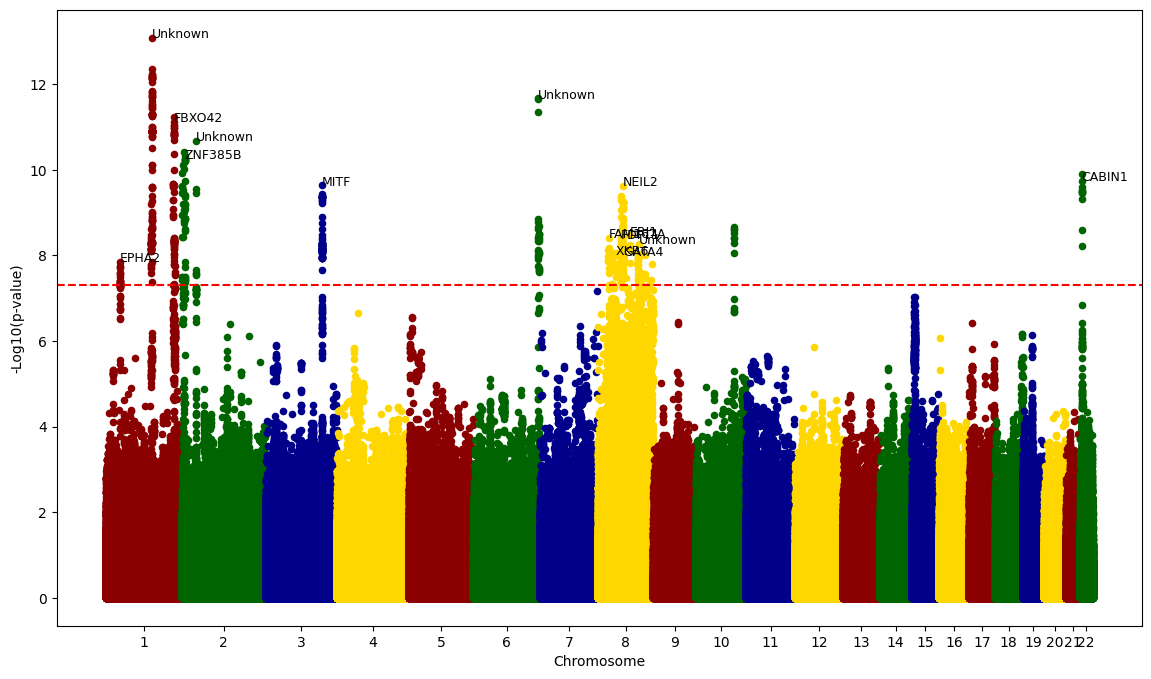

In [23]:
df_PATH = 'normalized_result/test_bin_out_firth_LV_radial_strain_global.regenie'
gene_name_PATH = "gene_name_df/LV_radial_strain_global.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_radial_strain_global.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)


Start plotting


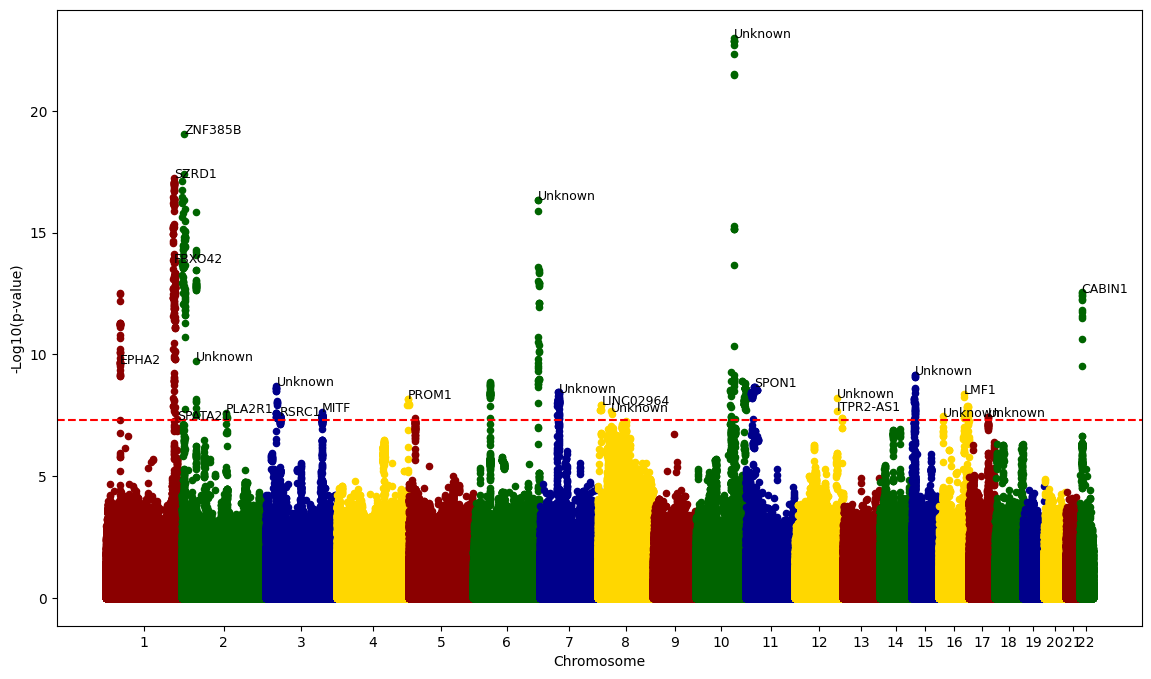

In [24]:
df_PATH = 'normalized_result/test_bin_out_firth_LV_circumferential_strain_global.regenie'
gene_name_PATH = "gene_name_df/LV_circumferential_strain_global.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_circumferential_strain_global.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)

Start plotting


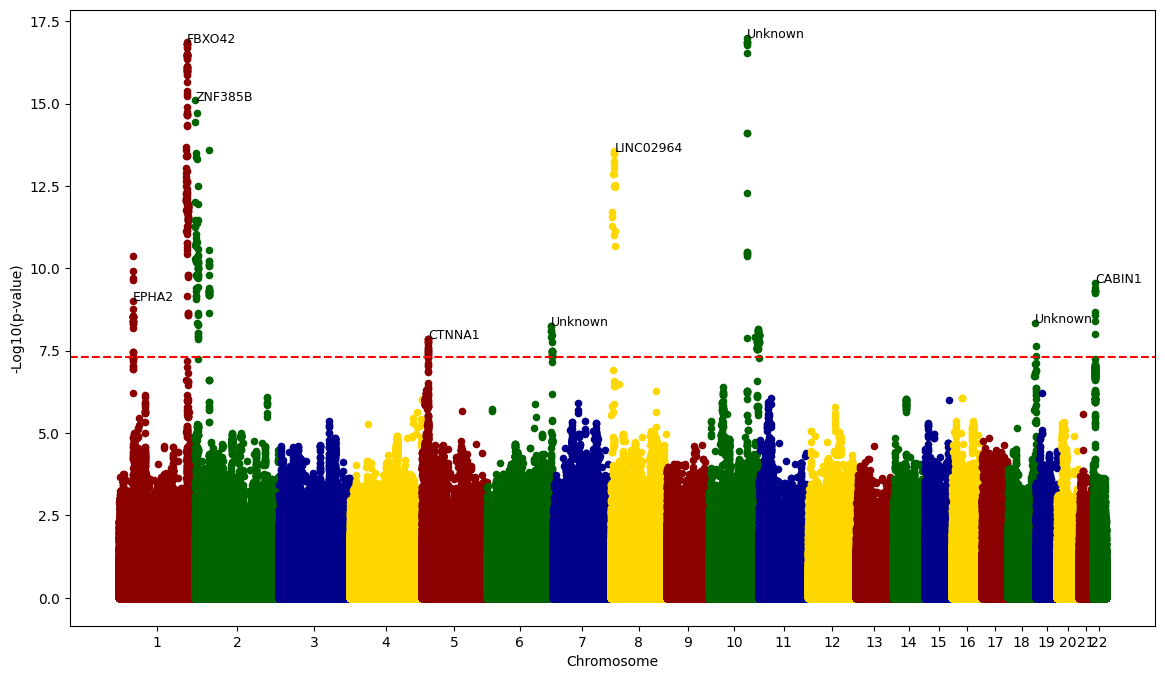

In [25]:
df_PATH = 'normalized_result/test_bin_out_firth_LV_ejection_fraction.regenie'
gene_name_PATH = "gene_name_df/LV_ejection_fraction.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_ejection_fraction.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)

Start plotting


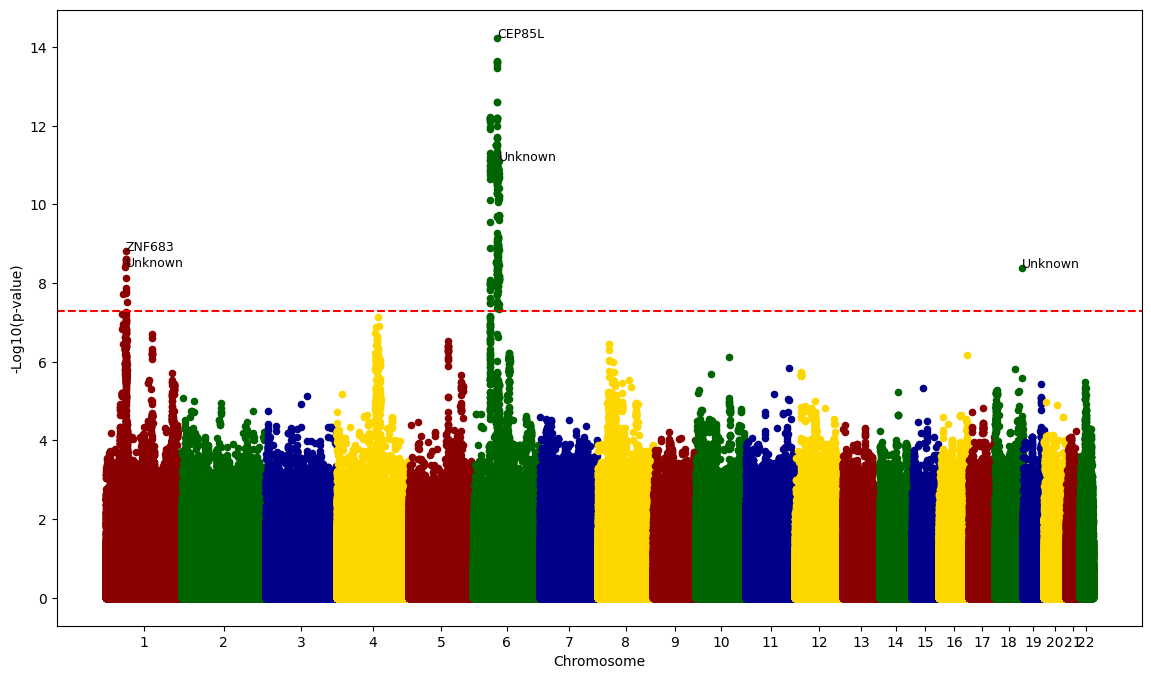

In [26]:
df_PATH = 'normalized_result/test_bin_out_firth_LV_longitudinal_strain_global.regenie'
gene_name_PATH = "gene_name_df/LV_longitudinal_strain_global.csv"
clumped_df_PATH =  f'clump_result/plink_clump_LV_longitudinal_strain_global.clumped'
plot_genomic_data(df_PATH,gene_name_PATH,clumped_df_PATH)

## Visualized RPS_Result

In [39]:
prs_result = pd.read_csv("PRS_Result/weight_file_LV_circumferential_strain_global-PRS_40-LV_circumferential_strain_global-N_487409-chrALL.csv")
prs_result

,#sampleID,sum_PRS,SNP_N
0,2210132_2210132,-1.091126,40
1,5803573_5803573,-1.775918,40
2,1898792_1898792,-1.123166,40
3,3342906_3342906,-1.165189,40
4,5111305_5111305,-1.445531,40
...,...,...,...
487404,1880826_1880826,-1.802167,40
487405,2351435_2351435,-2.338118,40
487406,5068817_5068817,-0.736045,40
487407,2992386_2992386,-0.973552,40


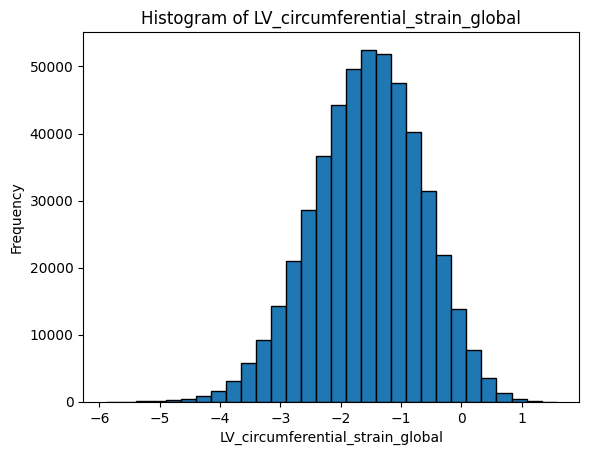

In [41]:
prs_result = pd.read_csv("PRS_Result/weight_file_LV_circumferential_strain_global-PRS_40-LV_circumferential_strain_global-N_487409-chrALL.csv")

pheno_name = "LV_circumferential_strain_global"
plt.figure()
plt.hist(prs_result.iloc[:, 1], bins=30, edgecolor='black')
plt.title(f'Histogram of {pheno_name}')
plt.xlabel(f'{pheno_name}')
plt.ylabel('Frequency')
plt.show()

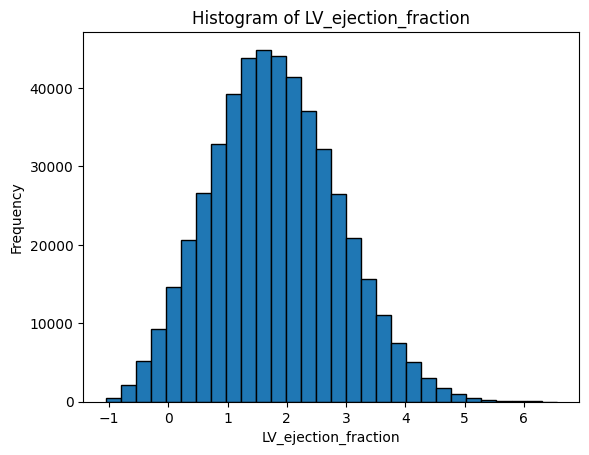

In [43]:
prs_result = pd.read_csv("PRS_Result/weight_file_LV_ejection_fraction-PRS_17-LV_ejection_fraction-N_487409-chrALL.csv")

pheno_name = "LV_ejection_fraction"
plt.figure()
plt.hist(prs_result.iloc[:, 1], bins=30, edgecolor='black')
plt.title(f'Histogram of {pheno_name}')
plt.xlabel(f'{pheno_name}')
plt.ylabel('Frequency')
plt.show()

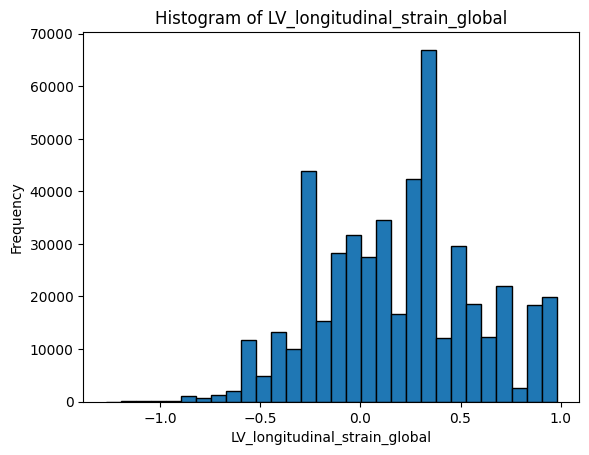

In [45]:
prs_result = pd.read_csv("PRS_Result/weight_file_LV_longitudinal_strain_global-PRS_8-LV_longitudinal_strain_global-N_487409-chrALL.csv")

pheno_name = "LV_longitudinal_strain_global"
plt.figure()
plt.hist(prs_result.iloc[:, 1], bins=30, edgecolor='black')
plt.title(f'Histogram of {pheno_name}')
plt.xlabel(f'{pheno_name}')
plt.ylabel('Frequency')
plt.show()

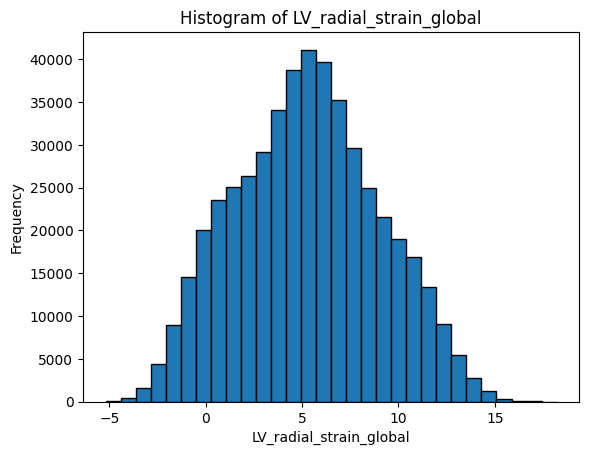

In [47]:
prs_result = pd.read_csv("PRS_Result/weight_file_LV_radial_strain_global-PRS_36-LV_radial_strain_global-N_487409-chrALL.csv")

pheno_name = "LV_radial_strain_global"
plt.figure()
plt.hist(prs_result.iloc[:, 1], bins=30, edgecolor='black')
plt.title(f'Histogram of {pheno_name}')
plt.xlabel(f'{pheno_name}')
plt.ylabel('Frequency')
plt.show()

### Visualization of the normalized result and unnormalized result

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
def cal_similarity(df, df_norm,col_name="weight"):
    col1 = df[col_name].values.reshape(-1, 1)
    col2 = df_norm[col_name].values.reshape(-1, 1)
    
    cos_sim = cosine_similarity(col1, col2)
    print(f'Cosine similarity: {cos_sim[0, 0]}')

In [27]:
cosine_similarity(result_unnorm["weight"].values.reshape(-1, 1),result["weight"].values.reshape(-1, 1))

array([[ 1.,  1., -1., ...,  1., -1.,  1.],
       [ 1.,  1., -1., ...,  1., -1.,  1.],
       [-1., -1.,  1., ..., -1.,  1., -1.],
       ...,
       [ 1.,  1., -1., ...,  1., -1.,  1.],
       [-1., -1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1., -1., ...,  1., -1.,  1.]])

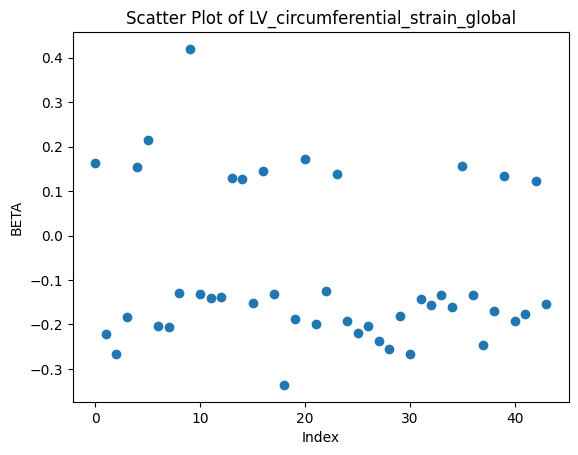

In [19]:
# Unnormalized
target = "LV_circumferential_strain_global"
result_unnorm = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.csv")
result_unnorm = result_unnorm.sort_values(by="rs_number")
result_unnorm 

plt.figure()
plt.scatter(result_unnorm.index, result_unnorm["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

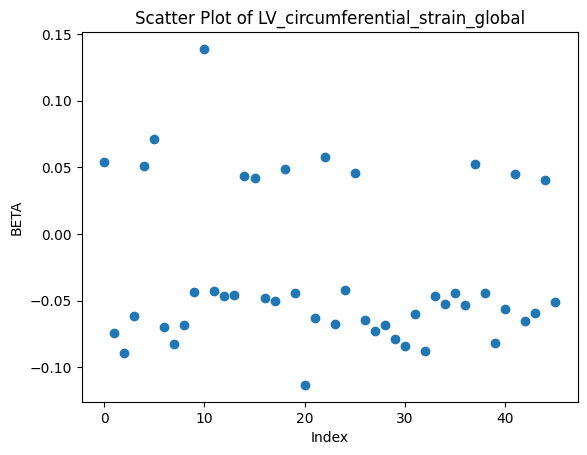

In [20]:
# normalized
target = "LV_circumferential_strain_global"
result = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.norm.csv")
result = result.sort_values(by="rs_number")
result 

plt.figure()
plt.scatter(result.index, result["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

In [9]:
cal_similarity(result_unnorm,result)

Cosine similarity: 1.0


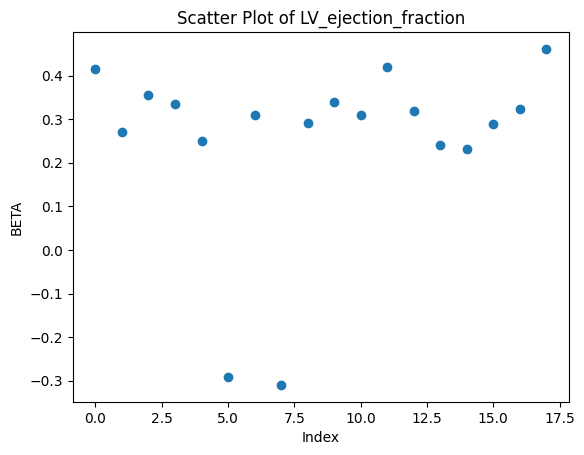

In [10]:
# Unnormalized
target = "LV_ejection_fraction"
result_unnorm = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.csv")
result_unnorm = result_unnorm.sort_values(by="rs_number")
result_unnorm 

plt.figure()
plt.scatter(result_unnorm.index, result_unnorm["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

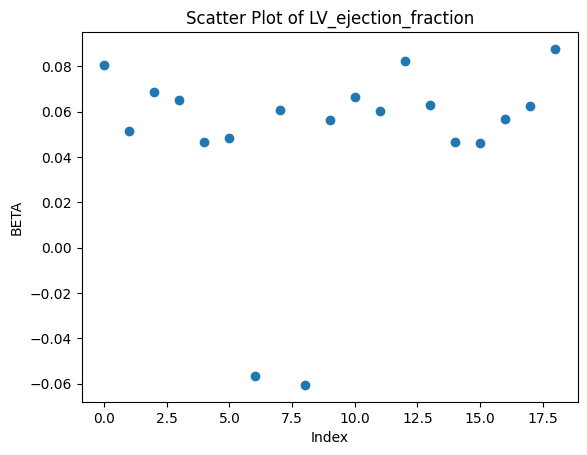

In [11]:
# normalized
target = "LV_ejection_fraction"
result = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.norm.csv")
result = result.sort_values(by="rs_number")
result 

plt.figure()
plt.scatter(result.index, result["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

In [12]:
cal_similarity(result_unnorm,result)

Cosine similarity: 1.0


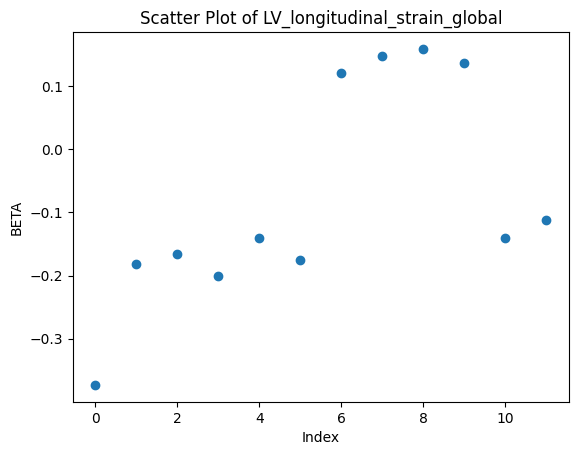

In [13]:
# Unnormalized
target = "LV_longitudinal_strain_global"
result_unnorm = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.csv")
result_unnorm = result_unnorm.sort_values(by="rs_number")
result_unnorm 

plt.figure()
plt.scatter(result_unnorm.index, result_unnorm["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

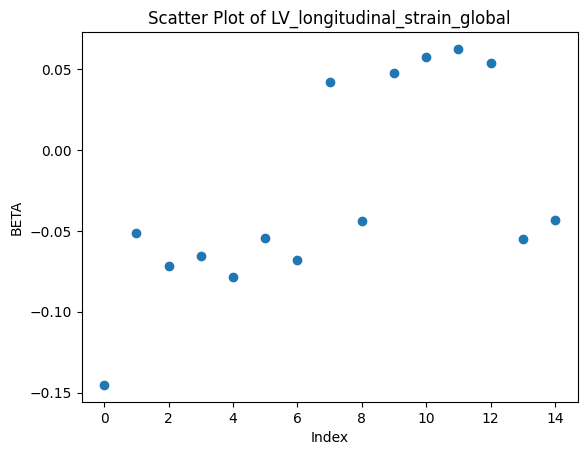

In [14]:
# normalized
target = "LV_longitudinal_strain_global"
result = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.norm.csv")
result = result.sort_values(by="rs_number")
result 

plt.figure()
plt.scatter(result.index, result["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

In [15]:
cal_similarity(result_unnorm,result)

Cosine similarity: 1.0


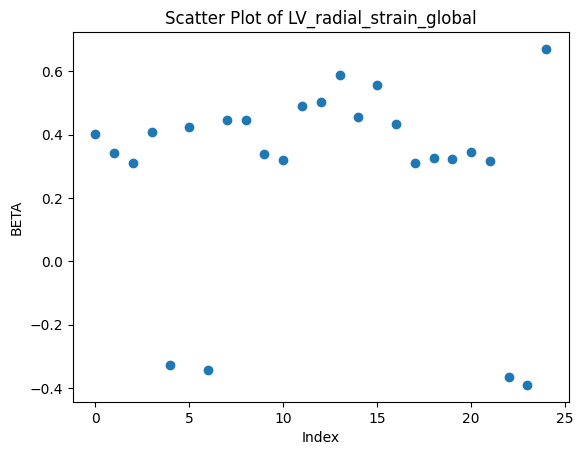

In [16]:
# Unnormalized
target = "LV_radial_strain_global"
result_unnorm = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.csv")
result_unnorm = result_unnorm.sort_values(by="rs_number")
result_unnorm 

plt.figure()
plt.scatter(result_unnorm.index, result_unnorm["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

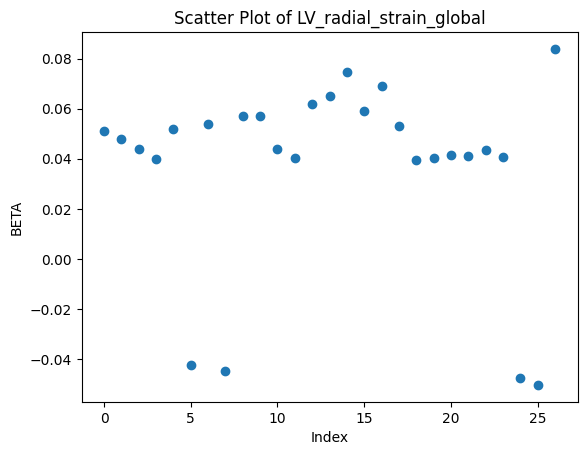

In [17]:
# normalized
target = "LV_radial_strain_global"
result = pd.read_csv(f"weights_PRS/SAIGE_weights/weight_file_{target}.norm.csv")
result = result.sort_values(by="rs_number")
result 

plt.figure()
plt.scatter(result.index, result["weight"])
plt.title(f'Scatter Plot of {target}')
plt.xlabel('Index')
plt.ylabel('BETA')
plt.show()

In [18]:
cal_similarity(result_unnorm,result)

Cosine similarity: 1.0


### Filter patients who are not in GWAS Study and does not have the genetic data(same group of people in the PRS calculation above), add a column to indicate whether the patient has HF

In [2]:
IMPUTED_PHENO_DATAPATH = "/gpfs/group/torkamani/bzhu/ukbb_project/ukbb_cardiac/new_target/data/phenotype_imputed.csv"
imputed_pheno_df = pd.read_csv(IMPUTED_PHENO_DATAPATH)
imputed_pheno_df

,Unnamed: 0,eid,instance_0.albumin_f30600,instance_0.cholesterol_f30690,instance_0.creatinine_f30700,instance_0.sitting_height_f20015,instance_0.body_mass_index_bmi_f21001,instance_0.body_fat_percentage_f23099,instance_0.whole_body_fat_mass_f23100,instance_0.creactive_protein_f30710,...,instance_3.Merged_Qualifications.CSEs_or_equivalent,instance_3.Merged_Qualifications.NVQ_or_HND_or_HNC_or_equivalent,instance_3.Merged_Qualifications.Other_professional_qualifications_eg_nursing_teaching,instance_3.Merged_Current_employment_status.In_paid_employment_or_self_employed,instance_3.Merged_Current_employment_status.Retired,instance_3.Merged_Current_employment_status.Looking_after_home_and_or_family,instance_3.Merged_Current_employment_status.Unable_to_work_because_of_sickness_or_disability,instance_3.Merged_Current_employment_status.Unemployed,instance_3.Merged_Current_employment_status.Doing_unpaid_or_voluntary_work,instance_3.Merged_Current_employment_status.Full_or_part_time_student
0,1,1000013,44.04,4.576,82.8,93.0,23.3553,22.8,15.9,0.45,...,0,0,0,0,1,0,0,0,0,0
1,2,1000024,43.03,5.531,65.2,91.0,22.6254,30.3,19.1,0.44,...,0,1,0,0,0,0,0,0,0,0
2,3,1000036,43.28,5.997,79.1,90.0,23.1084,17.3,11.4,0.51,...,0,0,1,0,1,0,0,0,0,0
3,4,1000048,41.47,4.997,121.4,92.0,21.9031,16.5,10.4,3.37,...,0,0,1,0,1,0,0,0,0,0
4,5,1000055,45.62,7.915,64.1,84.0,37.7940,47.9,43.5,3.26,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487144,487145,6025005,47.16,6.879,86.6,88.0,26.0771,23.7,17.4,0.86,...,1,0,0,0,1,0,0,0,0,0
487145,487146,6025012,43.42,4.252,56.1,85.0,28.8705,42.8,33.7,10.24,...,0,0,0,1,1,1,0,0,0,0
487146,487147,6025030,46.52,6.425,50.2,85.0,23.6488,30.5,18.7,1.92,...,0,0,0,0,1,0,0,0,0,0
487147,487148,6025049,47.54,5.331,73.4,87.0,29.3105,39.8,29.5,0.71,...,1,0,1,0,1,0,0,0,0,0


In [3]:
prs_result_id = pd.read_csv("PRS_Result/weight_file_LV_radial_strain_global-PRS_36-LV_radial_strain_global-N_487409-chrALL.csv")["#sampleID"].str.split("_").str[0]
prs_result_id

0         2210132
1         5803573
2         1898792
3         3342906
4         5111305
           ...   
487404    1880826
487405    2351435
487406    5068817
487407    2992386
487408    4102450
Name: #sampleID, Length: 487409, dtype: object

In [4]:
geno_ids = pd.read_csv("/gpfs/home/bzhu/work/ukbb_cardiac/new_target/GWA_tutorial/genotype_qc/12_mafhwe/geno_filter_12.fam",header=None, delim_whitespace=True).iloc[:,0]	
geno_ids = geno_ids.to_list()
print(len(geno_ids))
pheno_ids = pd.read_csv(f"../../../data/adjusted_filtered_LV_ejection_fraction.tsv", sep="\t")["FID"]
pheno_ids = pheno_ids.to_list()
print(len(pheno_ids))
gwas_ids = set(geno_ids) & set(pheno_ids)
gwas_ids = set(gwas_ids)
print(len(gwas_ids))

37217
35392
33421


In [5]:
# people who have genetic data and not in our gwas study

imputed_pheno_df = imputed_pheno_df[~imputed_pheno_df["eid"].isin(gwas_ids)]
imputed_pheno_df

,Unnamed: 0,eid,instance_0.albumin_f30600,instance_0.cholesterol_f30690,instance_0.creatinine_f30700,instance_0.sitting_height_f20015,instance_0.body_mass_index_bmi_f21001,instance_0.body_fat_percentage_f23099,instance_0.whole_body_fat_mass_f23100,instance_0.creactive_protein_f30710,...,instance_3.Merged_Qualifications.CSEs_or_equivalent,instance_3.Merged_Qualifications.NVQ_or_HND_or_HNC_or_equivalent,instance_3.Merged_Qualifications.Other_professional_qualifications_eg_nursing_teaching,instance_3.Merged_Current_employment_status.In_paid_employment_or_self_employed,instance_3.Merged_Current_employment_status.Retired,instance_3.Merged_Current_employment_status.Looking_after_home_and_or_family,instance_3.Merged_Current_employment_status.Unable_to_work_because_of_sickness_or_disability,instance_3.Merged_Current_employment_status.Unemployed,instance_3.Merged_Current_employment_status.Doing_unpaid_or_voluntary_work,instance_3.Merged_Current_employment_status.Full_or_part_time_student
0,1,1000013,44.04,4.576,82.8,93.0,23.3553,22.8,15.9,0.45,...,0,0,0,0,1,0,0,0,0,0
1,2,1000024,43.03,5.531,65.2,91.0,22.6254,30.3,19.1,0.44,...,0,1,0,0,0,0,0,0,0,0
2,3,1000036,43.28,5.997,79.1,90.0,23.1084,17.3,11.4,0.51,...,0,0,1,0,1,0,0,0,0,0
3,4,1000048,41.47,4.997,121.4,92.0,21.9031,16.5,10.4,3.37,...,0,0,1,0,1,0,0,0,0,0
4,5,1000055,45.62,7.915,64.1,84.0,37.7940,47.9,43.5,3.26,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487144,487145,6025005,47.16,6.879,86.6,88.0,26.0771,23.7,17.4,0.86,...,1,0,0,0,1,0,0,0,0,0
487145,487146,6025012,43.42,4.252,56.1,85.0,28.8705,42.8,33.7,10.24,...,0,0,0,1,1,1,0,0,0,0
487146,487147,6025030,46.52,6.425,50.2,85.0,23.6488,30.5,18.7,1.92,...,0,0,0,0,1,0,0,0,0,0
487147,487148,6025049,47.54,5.331,73.4,87.0,29.3105,39.8,29.5,0.71,...,1,0,1,0,1,0,0,0,0,0


In [3]:
from filter_pheno import add_visit_info,filtering_HF,filtering_MI
import pandas as pd
RECRUIT_DATE_PATH = "../../../data/instance_2_recruit_date.csv"
recruit_df = pd.read_csv(RECRUIT_DATE_PATH,usecols=["eid","recruit_date"])
df_finding_HF = pd.read_csv("../../../data/ukbb_HF_modeling_with_PRS.csv")
# df_finding_MI = pd.read_csv("../../../data/ukbb_MI_modeling_with_PRS.csv")
df_finding_HF = df_finding_HF.set_index("eid")
df_finding_HF

<ipython-input-3-1833b51d5723>:5: DtypeWarning: Columns (7,8,11,14,18,24,25,34,42,59,64,66,69,71,73,76,79,86,87,89,90,94,96,99,101,109,116,117,119,120,126,131,135,136,139,146,147,149,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df_finding_HF = pd.read_csv("../../../data/ukbb_HF_modeling_with_PRS.csv")


,Unnamed: 0,EHR_DCMP_strict,instance_0.INTVW_DCMP_strict,EHR_HCMP_strict,instance_0.INTVW_HCMP_strict,EHR_CMP_broad,instance_0.INTVW_CMP_broad,EHR_CMP_2nd,instance_0.INTVW_CMP_2nd,EHR_HF_broad,...,instance_3.INTVW_Chronic_pericarditis,instance_3.INTVW_Congenital_HD,instance_3.INTVW_Arrhythmia_brady,instance_3.INTVW_Arrhythmia_tachy,instance_3.INTVW_Arrhythmia_other,instance_3.INTVW_Cardiac_intervention_others,instance_3.INTVW_Hypertension,instance_3.INTVW_Renal_failure,instance_3.INTVW_Renal_failur_sig,instance_3.INTVW_All_death
eid,,,,,,,,,,,,,,,,,,,,,
1000013,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000024,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000036,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000048,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000055,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025030,502352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6025049,502353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6025051,502354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
positive_features = ["EHR_DCMP_strict","EHR_HCMP_strict","EHR_HF_broad","EHR_Ischemic_CMP"]
negative_features = ["EHR_CMP_2nd","EHR_HF_hypertensive","EHR_Myocarditis","EHR_VHD_rheumatic","EHR_VHD_others","EHR_Congenital_HD","EHR_Renal_failur_sig"]
all_f = positive_features + negative_features
x = df_finding_HF[~df_finding_HF[positive_features].isna().all(axis=1)][all_f]
x

,EHR_DCMP_strict,EHR_HCMP_strict,EHR_HF_broad,EHR_Ischemic_CMP,EHR_CMP_2nd,EHR_HF_hypertensive,EHR_Myocarditis,EHR_VHD_rheumatic,EHR_VHD_others,EHR_Congenital_HD,EHR_Renal_failur_sig
eid,,,,,,,,,,,
1000055,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000131,NaN,NaN,2018-10-15,NaN,NaN,NaN,NaN,NaN,2018-11-30,NaN,NaN
1000290,NaN,NaN,2008-12-29,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-09,NaN
1000746,NaN,NaN,2019-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001054,NaN,NaN,2017-01-26,2017-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6024096,NaN,NaN,2018-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6024361,NaN,NaN,2013-02-04,NaN,NaN,NaN,NaN,NaN,2012-12-20,NaN,NaN
6024378,NaN,NaN,2022-01-23,NaN,NaN,NaN,NaN,2022-01-23,2018-09-06,NaN,2022-01-25


In [5]:
filtered_df = x[x[negative_features].isna().all(axis=1)]

filtered_df


,EHR_DCMP_strict,EHR_HCMP_strict,EHR_HF_broad,EHR_Ischemic_CMP,EHR_CMP_2nd,EHR_HF_hypertensive,EHR_Myocarditis,EHR_VHD_rheumatic,EHR_VHD_others,EHR_Congenital_HD,EHR_Renal_failur_sig
eid,,,,,,,,,,,
1000055,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000746,NaN,NaN,2019-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001054,NaN,NaN,2017-01-26,2017-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001149,NaN,NaN,1999-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001213,NaN,NaN,2013-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6023691,NaN,NaN,2018-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023966,NaN,NaN,2022-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6024096,NaN,NaN,2018-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We include everyone in the study, including visit0,1,2,EHR

In [7]:
# Negative Features: 
negative_features = ["CMP_2nd","HF_hypertensive","Myocarditis","VHD_rheumatic","VHD_others","Congenital_HD","Renal_failur_sig"]

# Postive Features:
positive_features = ["DCMP_strict","HCMP_strict","HF_broad","Ischemic_CMP"]
x = df_finding_HF.copy()

prevalent_id = []
target = [0,1,2,"EHR"]
# filtering_HF(x,recruit_df,negative_features,positive_features,"EHR")
for i in target:
    prevalent_id.append(filtering_HF(x,recruit_df,negative_features,positive_features,i))

flattened_list_HF = [item for sublist in prevalent_id for item in sublist]
flattened_list_HF = list(set(flattened_list_HF))
print(len(flattened_list_HF))


11694


In [13]:
with open("../../../data/Heart_Failure_ids.txt", "w") as file:
    for id in flattened_list_HF:
        file.write(str(id) + '\n')
    